# Libraries

In [1]:
import csv
import os
import json
import umap
import textacy
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Articles

In [2]:
articles = []

dir = "data/biomass/"
files = os.listdir(dir)  # Set folder and files

for filename in files:

    f = open(dir + filename)
    r = f.read()
    data = json.loads(r)

    # Parse

    try:

        year = int(data[0]["publish_date"].split(" ")[0].split("-")[0])  # Set year

        title = data[0]["title"]  # Set Title

        url = data[0]["url"]  # Set URL
        if any(x in url for x in {"feeds.", "rss.", "briefing"}):
            continue  # Blacklist (Bob Dylan's case)
        # if not any(
        #     x in url
        #     for x in {
        #         "wsj.com",
        #         "usatoday.com",
        #         "nytimes.com",
        #         "latimes.com",
        #         "nypost.com",
        #         "washingtonpost.com",
        #         "chicagotribune.com",
        #         "chron.com",
        #         "nydailynews.com",
        #         "theguardian.com",
        #     }
        # ):
        #     continue  # Whitelist

        entities = data[0]["story_tags"]  # Set sentities
        if len(entities) > 100:
            continue  # Set max
        if len(entities) <= 1:
            continue  # Set min

        subjects = []
        orgs = []
        people = []

        for entity in entities:

            name = entity["tag"]

            if name[0] == "—":
                continue  # Remove listings
            if name.startswith("geonames_"):
                continue  # Skip geotag
            if "readability" in name:
                continue  # Clean
            if "cliff_clavin_" in name:
                continue  # Clean
            if "nyt_labeller" in name:
                continue  # Clean

            name = " ".join(name.split())  # Merge multiple spaces
            name = name.replace(".", "")  # Remove dots
            name = name.replace(",", "")  # Remove commas

            if entity["tag_set"] == "nyt_labels":
                subjects.append(name)

            elif entity["tag_set"] == "cliff_organizations":
                if name.startswith("US "):
                    name = name[3:]  # Remove prefix
                if name.endswith(" Corp"):
                    name = name[:-5]  # Remive postfix
                if name.endswith(" Inc"):
                    name = name[:-4]  # Remive postfix
                if name.endswith(" LCC"):
                    name = name[:-4]  # Remive postfix
                if name[0].islower():
                    continue  # Remove lowercase
                if name[1].isupper():
                    continue  # Remove acronyms
                orgs.append(name)

            elif entity["tag_set"] == "cliff_people":
                if "/" in name:
                    continue  # Clean
                if name[1].isupper():
                    continue  # Remove uppercase
                if name[0].islower():
                    continue  # Remove lowercase
                if len(name.split(" ")) == 1:
                    continue  # remove those with no family name
                people.append(name)

        if len(orgs) > 0 and len(subjects) > 0:
            articles.append(
                [
                    year,
                    title,
                    url,
                    list(set(subjects)),
                    list(set(orgs)),
                    list(set(people)),
                ]
            ) # Add these articles with actors only


    except:
        continue  # In case of error


articles = pd.DataFrame(
    articles, columns=["year", "title", "url", "subjects", "orgs", "people"]
)  # Dataset

articles = articles.drop_duplicates(subset=["url"])  # Remove articles with the same URL

print('\n' + str(articles.shape[0]))

articles.sample(10)



18153


,year,title,url,subjects,orgs,people
19165,2020,U.S. consumes record amount of renewable energ...,http://www.theuknews.com/news/266733627/us-con...,"[energy and power, environment, light, electri...","[Xinhua, Energy Information Administration]",[]
5240,2013,Distillery secures green investment,http://www.bbc.co.uk/news/uk-scotland-scotland...,[finances],[Tomatin Distillery secures green bank investm...,"[Takara Shuzo, Shaun Kingsbury, Vince Cable]"
3900,2014,Blog Post: HeadsUp for Washington State: Court...,http://www.lexisnexis.com/legalnewsroom/litiga...,"[global warming, environment, chemistry, light...","[Department of Ecology, Washington Supreme Cou...",[]
7296,2020,Researchers Produce New Energy From Biomass,http://kayhan.ir/en/news/77736/researchers-pro...,"[energy and power, light, electric light and p...",[Mechanical Engineering Department of Iranian ...,[]
16703,2016,Close to Rs 1000 crores investments announced ...,http://www.financialexpress.com/article/health...,"[politics and government, mergers acquisitions...","[Mission Embassy, Weismann Institute, Genome V...","[Susil Premajayantha, Ada Yonath, Nils Ragnar ..."
12641,2016,Women can power alternative energy solutions f...,http://www.theeastafrican.co.ke/OpEd/comment/W...,"[energy and power, economic conditions and tre...","[World Bank, African Development Bank, Interna...",[]
18881,2019,Trickle of States Around the World Producing A...,https://thewire.in/environment/trickle-of-stat...,"[environment, electric light and power, oil (p...",[Institute for Energy Economics and Financial ...,"[Tim Buckley, Euan McTurk, Narendra Modi]"
7280,2020,'They just pull up everything!' Chinese fleet ...,https://www.theguardian.com/environment/2020/a...,"[fish and other marine life, animals, fishing ...","[Galápagos Marine Reserve, Overseas Developmen...","[Roque Sevilla, Milton Castillo, Simon J Pierc..."
3295,2018,France is Being Invaded By Giant Killer Worms,https://earther.com/france-is-being-invaded-by...,"[animals, medicine and health]","[PeerJ, National Museum of Natural History]","[Pierre Gros, Sébastien Sant, Laurent Charles,..."
10336,2019,Forest Products Workers Discuss Policies That ...,https://www.prnewswire.com:443/news-releases/f...,"[politics and government, law and legislation,...","[Pulp & Paperworkers' Resource Council, Capito...",[David Wise]


## Entities

In [3]:
entities = np.empty((0, 12), dtype=object)

years_template = {
    2011: 0,
    2012: 0,
    2013: 0,
    2014: 0,
    2015: 0,
    2016: 0,
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 0,
}

for index, row in articles.iterrows():

    url = row["url"]
    year = row["year"]
    title = row["title"]
    cooccurrences = list(set(row["subjects"] + row["orgs"] + row["people"]))

    for entity in row["subjects"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "subject",
                            1,
                            None,
                            None,
                            None,
                            None,
                            None,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][8][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 8][0][year] += 1  # Year
            entities[index, 9][0].append(url)  # URL
            entities[index, 10][0].append(title)  # Title
            entities[index, 11][0] += co  # Co-occurrences

    for entity in row["orgs"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "org",
                            1,
                            None,
                            None,
                            None,
                            None,
                            None,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][8][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 8][0][year] += 1  # Year
            entities[index, 9][0].append(url)  # URL
            entities[index, 10][0].append(title)  # Title
            entities[index, 11][0] += co  # Co-occurrences

    for entity in row["people"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "person",
                            1,
                            None,
                            None,
                            None,
                            None,
                            None,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][8][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 8][0][year] += 1  # Year
            entities[index, 9][0].append(url)  # URL
            entities[index, 10][0].append(title)  # Title
            entities[index, 11][0] += co  # Co-occurrences


entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        'x',
        'y',
        'cluster',
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset

entities_all.sort_values(by=["frequency"], ascending=False).head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
14,environment,subject,7515,None,None,None,None,None,"{2011: 184, 2012: 147, 2013: 355, 2014: 489, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[Greenpeace India, Bhure Lal, Aishwarya Sudhir..."


# Treatment

## Frequency Scale

In [4]:
frequency = entities_all['frequency'].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
frequency_scaled
# df = pd.DataFrame(x_scaled)
entities_all['frequency_norm'] = frequency_scaled

entities_all.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
40916,William County,person,1,None,None,None,None,None,"{2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, ...",[https://www.princewilliamtimes.com/news/clean...,[Clean Virginia backs candidates ditching Domi...,"[politics and government, Jeremy McPike, Danic...",0.0


## Entity Filter

In [5]:
n = 50 # Number of rows by type

top_subjects = entities_all.loc[entities_all['type'] == 'subject'].sort_values(by=["frequency"], ascending=False).head(n)
top_orgs = entities_all.loc[entities_all['type'] == 'org'].sort_values(by=["frequency"], ascending=False).head(n)
top_people = entities_all.loc[entities_all['type'] == 'person'].sort_values(by=["frequency"], ascending=False).head(n)

entities = pd.concat([top_subjects, top_orgs, top_people])

entities.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
4003,Xi Jinping,person,61,None,None,None,None,None,"{2011: 0, 2012: 0, 2013: 0, 2014: 2, 2015: 10,...",[http://www.huffingtonpost.com/ellen-moyer-phd...,"[Ellen Moyer, Ph.D.: It's Time to Fix the Cli...","[politics and government, global warming, envi...",0.007985


## Linear Regression

In [6]:
# For each

for i, row in entities.iterrows():
    
    x = list(row['years'].keys())
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row['years'].values())

    regression = LinearRegression()
    regression.fit(x, y)

    slope = regression.coef_[0]
    entities.at[i, 'slope'] = slope


# Average and slope difference for subjects

entities_subjects = entities.loc[entities['type'] == 'subject']
average_subjects = entities_subjects['slope'].mean()
for i, row in entities_subjects.iterrows():
    entities.at[i, 'slope'] = row['slope'] - average_subjects


# Average and slope difference for people and organizations

entities_nosubjects = entities.loc[entities['type'] != 'subject']
average_nosubjects = entities_nosubjects['slope'].mean()
for i, row in entities_nosubjects.iterrows():
    entities.at[i, 'slope'] = row['slope'] - average_nosubjects


# entities.sort_values(by=["slope"], ascending=False).head(1)
# average_subjects, average_nosubjects
entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
79,air pollution,subject,3313,43.760606,None,None,None,None,"{2011: 72, 2012: 53, 2013: 157, 2014: 221, 201...",[http://www.miamiherald.com/2014/06/02/4153647...,[PSC member: new EPA plan will drive up power ...,"[Louisiana Public Service, environment, electr...",0.440777


## Colors

In [7]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():
    
    if row['type'] != 'subject':
        entities.at[i, 'color'] = mcolors.to_hex(cmap(norm(row['slope']))) # Actors
    else:
        entities.at[i, 'color'] = '#CCCCCC' # Subjects

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
14,environment,subject,7515,135.069697,#CCCCCC,None,None,None,"{2011: 184, 2012: 147, 2013: 355, 2014: 489, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[Greenpeace India, Bhure Lal, Aishwarya Sudhir...",1.0


# Embedding

## Term Frequency

In [8]:


doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(
    # entities["cooccurrences"].tolist(), tf_type="linear", idf_type="standard"
    entities["cooccurrences"].tolist(), tf_type="linear", idf_type="smooth"
)

list(dictionary.items())[:5]


[('Greenpeace India', 23850),
 ('Bhure Lal', 6904),
 ('Aishwarya Sudhir', 1295),
 ('Ramachandra University', 50015),
 ('University of Edinburgh', 62033)]

## UMAP

In [9]:

reducer = umap.UMAP(
    random_state=42, n_components=2, n_neighbors=2, min_dist=0.1, metric="hellinger"
)

embedding = reducer.fit_transform(doc_term_matrix) # Reducer
embedding = align_points_to_grid(embedding) # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900)) # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0 # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

entities.sample(1)


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


 * creating mesh with size 39 39
 * filling mesh


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
1171,Amarinder Singh,person,50,-0.921394,#465ecf,373,226,None,"{2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, ...",[https://www.newslaundry.com/shorts/prakash-ja...,[Prakash Javadekar was to help tackle Delhi’s ...,"[politics and government, Union Ministry of En...",0.006521


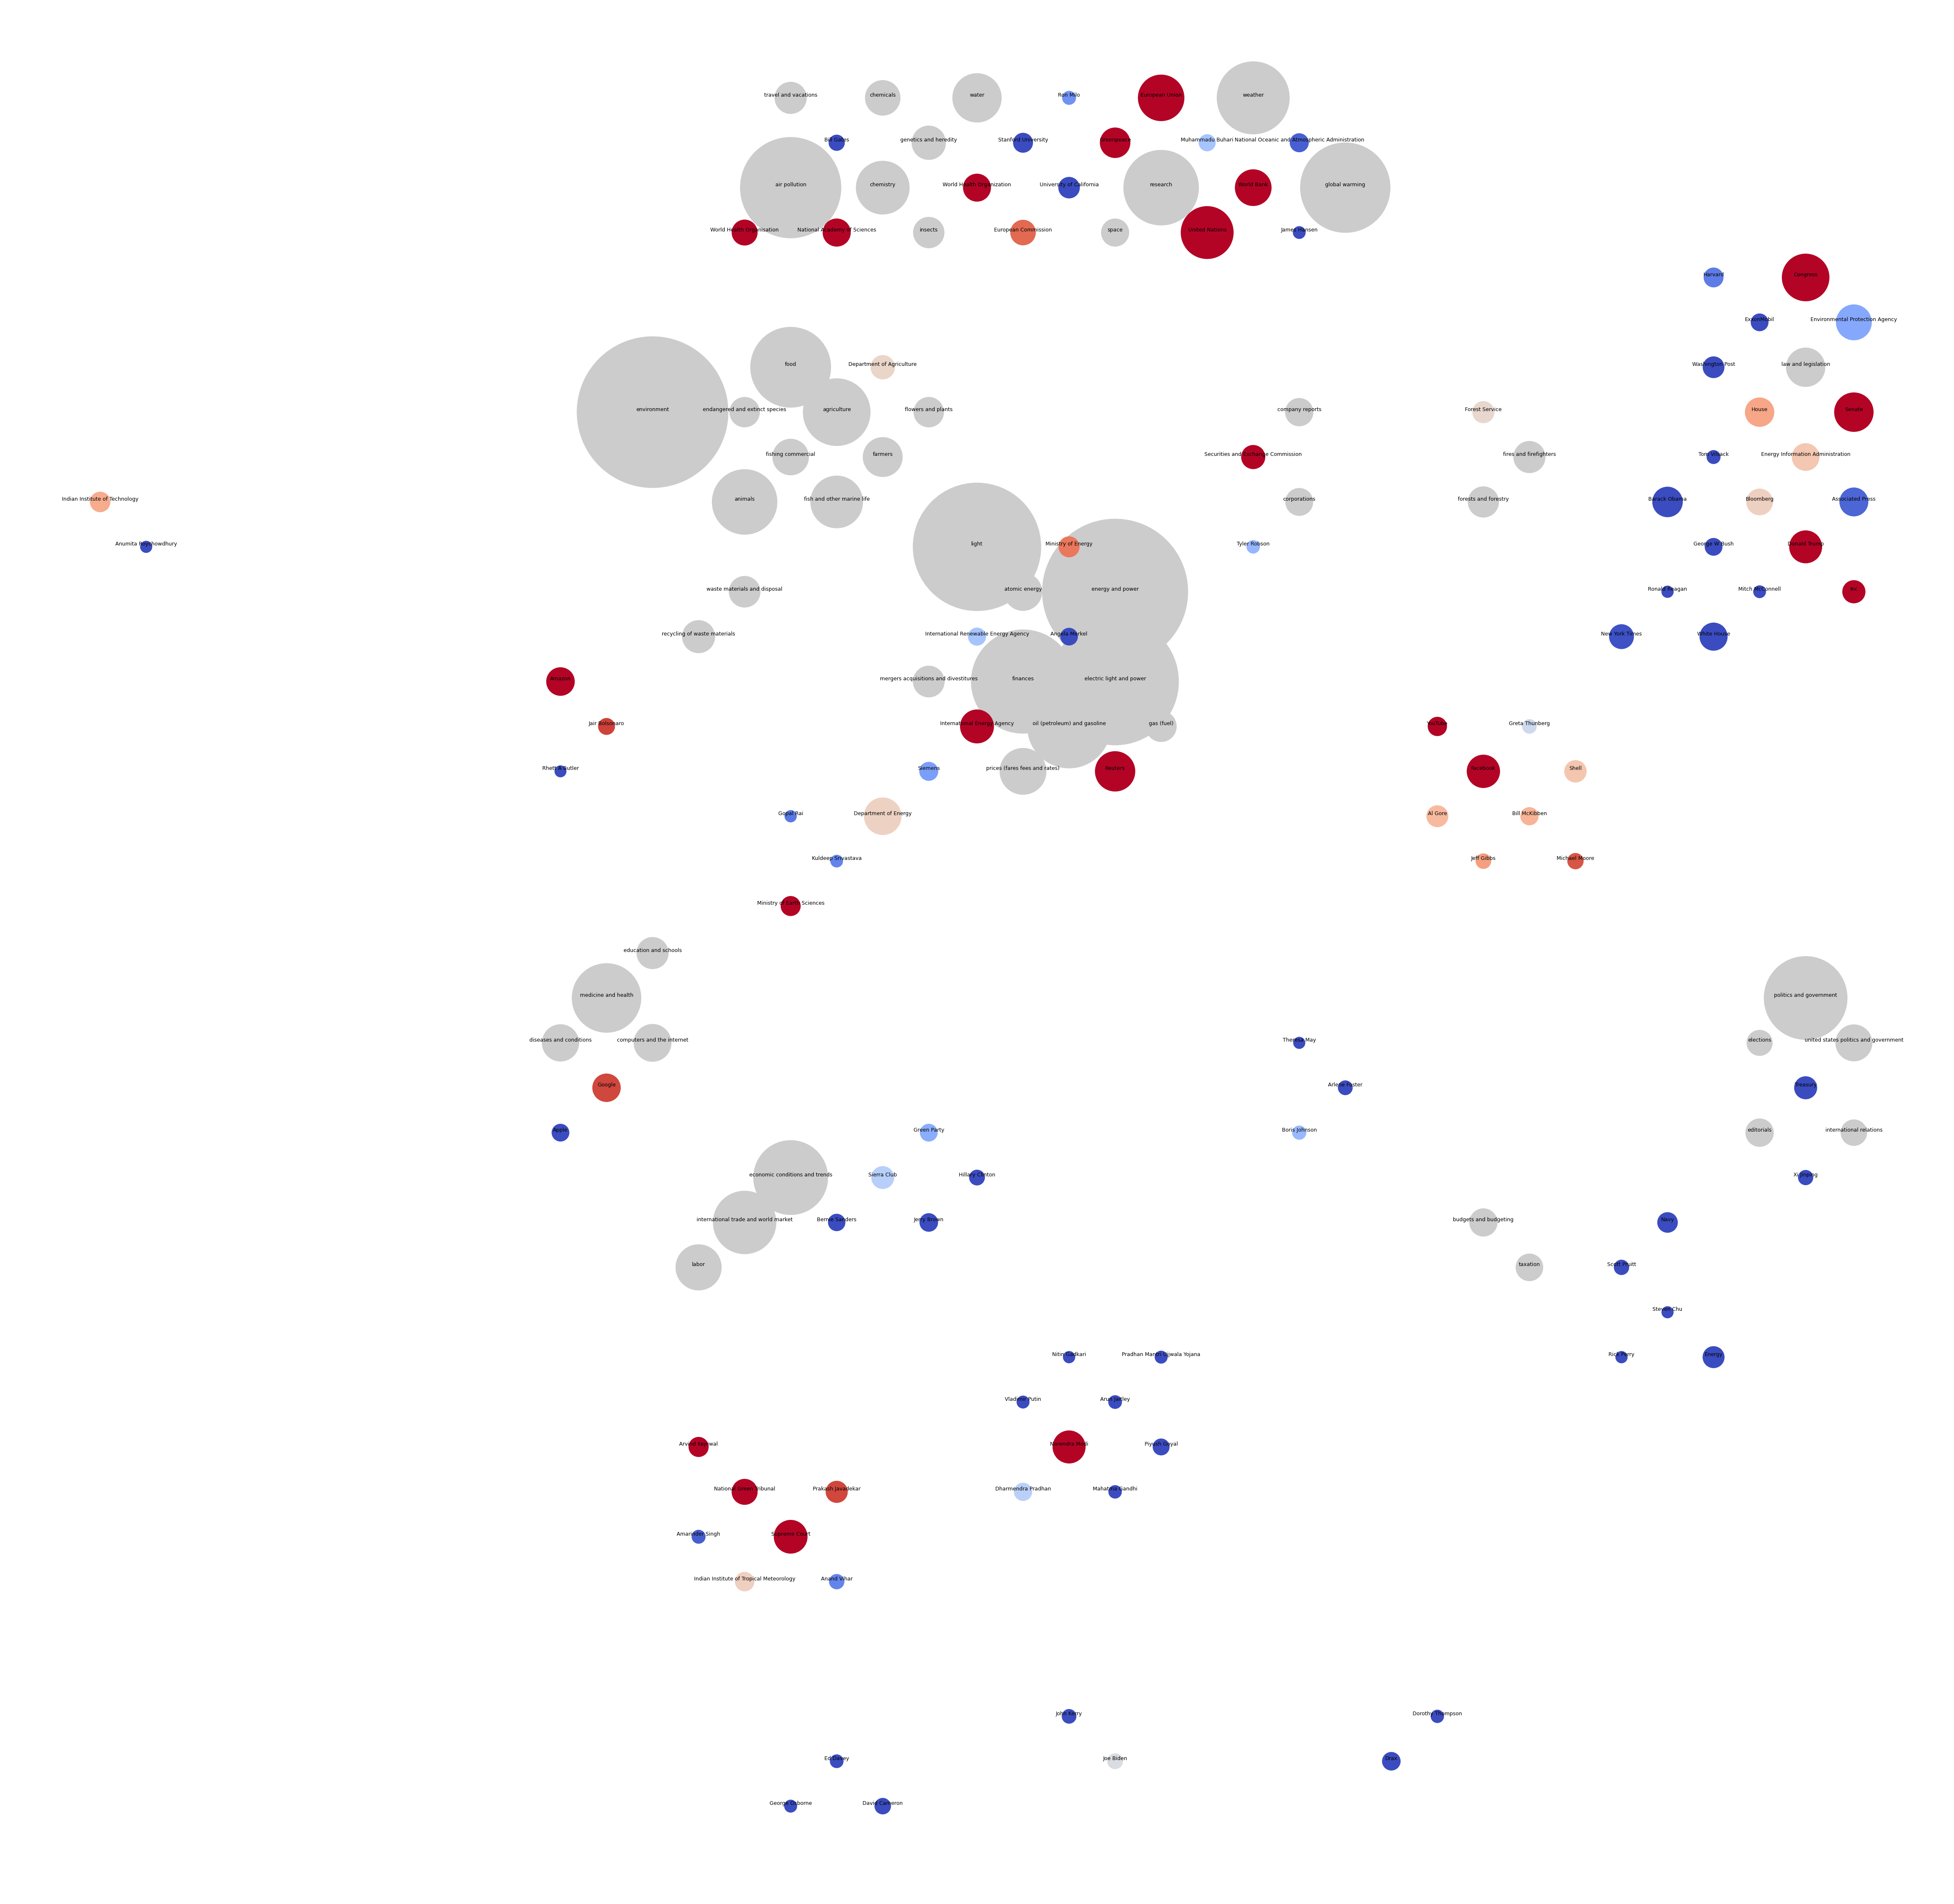

In [10]:
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")

## Clustering

[['diseases and conditions' -1]]


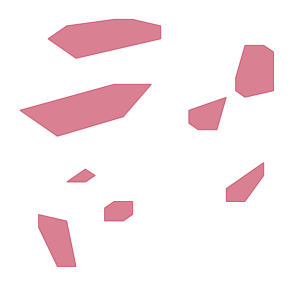

In [11]:
clusterer = hdbscan.HDBSCAN(
    min_samples=3,  # min_samples = number of close elements to create a set
    min_cluster_size=4,
    gen_min_span_tree=False,
    leaf_size=3,
    cluster_selection_epsilon=0.3,  # cluster_selection_epsilon = radius
)

entities_nosubjects = entities.loc[entities["type"] != "subject"]
embedding_nosubjects = entities_nosubjects[["x", "y"]].to_numpy()

clusterer.fit(embedding_nosubjects)
clusters = clusterer.labels_
# clusters = np.where(clusters == -1, None, clusters)  # Replace -1 with None

entities = entities.assign(cluster=-1)  # Clean the cluster columns

for count, (index, row) in enumerate(entities_nosubjects.iterrows()):
    entities.loc[index, "cluster"] = clusters[count] # Write cluster number

print(entities.sample(1)[["name", "cluster"]].to_numpy()) # Print one sample


# Plotting

plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(clusters.tolist()) # Make the list of clusters
clusters.remove(-1) # Remove None

for counter, cluster in enumerate(clusters):

    rows = entities.loc[entities["cluster"] == cluster] # Rows

    points = []  # Points
    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    plt.fill(x_hull, y_hull, "--", c="#b40426", alpha=0.5) # Plot


In [12]:
entities['cluster'] = '-1'

def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_
    
    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, 'cluster'] = prefix + str(clusters[count])
        else:
            entities.loc[index, 'cluster'] = str(clusters[count])
    
cluster_computing(entities.loc[(entities["type"] != "subject") & (entities["slope"] > 0)], 'p_', entities)
cluster_computing(entities.loc[(entities["type"] != "subject") & (entities["slope"] < 0)], 'n_', entities)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
1653,education and schools,subject,309,-18.79697,#CCCCCC,352,499,-1,"{2011: 6, 2012: 3, 2013: 22, 2014: 31, 2015: 3...",[http://www.dnaindia.com/delhi/report-in-a-fir...,"[In a first, Delhi University college sets up ...","[Forest Research Institute, Delhi University, ...",0.04099


{'p_3', 'p_0', 'p_2', 'p_1', 'n_5', 'n_3', 'n_0', 'n_1', 'n_2', 'n_4'}


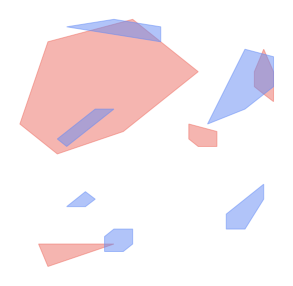

In [13]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())
clusters.remove("-1")  # Remove -1

print(clusters)

for counter, cluster in enumerate(clusters):

    rows = entities.loc[entities["cluster"] == cluster]  # Rows
    points = []  # Points
    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)
    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])
    if cluster[0] == 'p':
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    else:
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


# Save

In [14]:
entities.to_csv("src/data/entities.csv", index=False)